## Train an object detection network on boggle boards

In this notebook, I'm using the dataset from Roboflow: https://public.roboflow.ai/object-detection/boggle-boards to try and create an object detection model to extract letters from images of boggle boards.

The goal is to make a program that can play Boggle, using a picture of a board as input.

This first step is to create a model that can identify letters in a grid. We use the PyTorch and Albumentations library to build a neural network to predict bounding boxes, and eventually classify the resulting letters.

In [1]:
import os
import torch
import xml.etree.ElementTree as ET
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pac
import albumentations as A
from albumentations.pytorch import ToTensorV2

import plot_utils
import data_utils


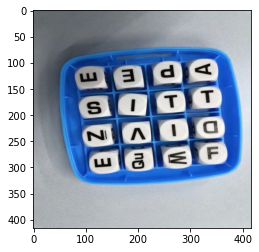

In [2]:
# have a look at the dataset
DATA_DIR = "./boggle_boards/export"

# .jpg, .xml
_files = os.listdir(DATA_DIR)
img = cv2.imread(os.path.join(DATA_DIR, _files[2])) # mod 2 = 0 index for .jpg file
plt.imshow(img);

In [3]:
# get raw data
raw_data = data_utils.getData(_files, DATA_DIR)


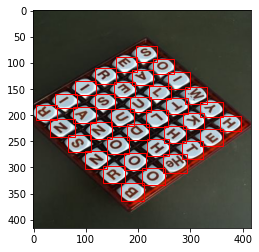

In [4]:
# plot some data with bounding boxes:
plot_utils.plotBB('04dcdbd29ee6e8077089edee1e924672', raw_data)

## make an object detection NNet
We have a regressor model for bounding boxes and a classification model for letters
We add the losses and run backprop

We need to develop a dataset class, dataloader class and the network.
We use this as a guide: https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/

In [5]:
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import distance_box_iou_loss, RoIPool
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from itertools import chain


import training_utils
import network_specs

Here we set up the data, including splitting into training and test sets, create the dataloaders and setting up transforms.

In [6]:
# extract the filenames that we want to keep, and create a label encoder from all available labels

# convert all_data to tensors
labels = []
all_files = []

# only keep filepaths with exactly 16 observations - 263 raw observations
for key, obs in raw_data.items():
    if len([k[0] for k in obs['bbox']]) == 16:
        all_files.append(key)
        labels.append([k[0] for k in obs['bbox']])

In [7]:
FILENAMES = np.array(all_files)
BATCH_SIZE = 64
FORMAT = 'pascal_voc'

# encode all labels (for when we get to classification)
le = LabelEncoder()
le.fit(np.unique(list(chain(*labels))))

# note we have run into this issue: https://github.com/albumentations-team/albumentations/issues/903
# fixed using by editing normalize_bbox in bbox_utils.py 
aug_transform = A.Compose([
    # A.HorizontalFlip(p = 0.5),
    # A.RandomBrightnessContrast(p = 0.5),
    A.ColorJitter(p = 0.9),
    # A.InvertImg(p = 0.5),
    # A.RandomRotate90(p = 0.5),
    A.RandomSizedBBoxSafeCrop(height = 416, width = 416, p = 0.5),
    A.PixelDropout(p = 0.5),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
    ToTensorV2()
    
],
bbox_params = A.BboxParams(format = FORMAT, label_fields = ['class_labels'])
)

split = train_test_split(
            FILENAMES,
            test_size = 0.2,
            random_state = 42
            )
            
trainFiles = data_utils.ObjDetectDataset(split[0], DATA_DIR, le, FORMAT, aug_transform)
testFiles = data_utils.ObjDetectDataset(split[1], DATA_DIR, le, FORMAT, aug_transform)
print(len(trainFiles), len(testFiles))

trainDL = DataLoader(trainFiles, batch_size=BATCH_SIZE)
testDL = DataLoader(testFiles, batch_size=BATCH_SIZE)

# cleanup
del raw_data

210 53


We can start to view our images against their transforms (noting that the original image provided has already been transformed!).
(note also, appears black due to inclusion of normalisation transform)


In [8]:
# create an iterator
k = iter(trainFiles)

In [9]:
# run as many times as you like to see a new image
img, label, bbox = next(k)
transformed = aug_transform(image = img.permute(1, 2, 0).detach().numpy(), bboxes = bbox, class_labels = label)

tformed_img = torch.Tensor(transformed['image'])
tformed_bbox =np.int64(np.array(transformed['bboxes'] ))

# set up plot
fig, ax = plt.subplots(1,2, figsize = (10, 10))
ax[0].imshow(img.permute(1,2,0))
ax[1].imshow(tformed_img.permute(1,2, 0))

# transformed image
for bb in tformed_bbox:
    rectangle = pac.Rectangle(
        (bb[0], bb[1]),
        abs(bb[2] - bb[0]),
        abs(bb[3] - bb[1]),
        fc = 'none',
        ec='red')
    ax[1].add_patch(rectangle)

# original image (from pipeline - already transformed)
for bb in bbox:
    rectangle = pac.Rectangle(
        (bb[0], bb[1]),
        abs(bb[2] - bb[0]),
        abs(bb[3] - bb[1]),
        fc = 'none',
        ec='red')
    ax[0].add_patch(rectangle)
plt.show();

NameError: name 'DATA_DIR' is not defined

In [12]:
def calcHout(Hin, padding, dilation, kernel_size, stride):
    return (Hin + 2 * padding - dilation*(kernel_size - 1) - 1) /  stride + 1

Hin = 416

Hout1 = calcHout(Hin, 0, 1, 5, 1)
Hout2 = calcHout(Hout1, 0, 1, 2, 2)
Hout3 = calcHout(Hout2, 0, 1, 5, 1)
Hout4 = calcHout(Hout3, 0, 1, 2, 2)
Hout5 = calcHout(Hout4, 0, 1, 6, 1)
Hout6 = calcHout(Hout5, 0, 1, 2, 2)
print(Hout1, Hout2, Hout3, Hout4, Hout5, Hout6)

412.0 206.0 202.0 101.0 96.0 48.0


In [42]:
Hin = 16
calcHout(Hin, 0, 1, 4, 1)

13.0

In [ ]:
# set up a random grid of values for tuning - range 0.0001 to 1
learning_rates = 10 ** (-4 * np.random.uniform(low = 0.35, high = 1, size = (6,)))
decay =  10 ** (-4 * np.random.uniform(low = 0.35, high = 1, size = (6,)))

# # sampled uniformly from log space
fig = plt.figure()
ax = plt.gca()
ax.scatter(decay, learning_rates)
ax.set_yscale('log')
ax.set_xscale('log')


In [ ]:
## L1 LOSS
criterion = nn.SmoothL1Loss() 
criterion_handler = lambda pred, actual: criterion(pred, torch.flatten(actual, 1))

EPOCHS = 20

all_results = dict()
for d, lr in zip(decay, learning_rates):
    print(round(d, 6), round(lr, 6))
    net = ObjectDetector(16)
    optimizer = optim.Adam(net.parameters(), lr = lr, weight_decay=d)
    results = train_and_validate(net, EPOCHS, trainDL, testDL, criterion_handler, optimizer, k = 5)
    all_results['lr_' + str(round(lr, 6)) + '_d_' + str(round(d,6))] = pd.DataFrame(results)

In [ ]:

res_df = pd.DataFrame.from_dict({(i,j): all_results[i][j] for i in all_results.keys() for j in all_results[i].keys()}, orient = 'index').reset_index()
res_df.rename(columns = {'level_0':'params', 'level_1': 'dataset'}, inplace=True)
to_plot = res_df.melt(id_vars = ['params', 'dataset'], value_vars = [i for i in range(EPOCHS)], var_name = 'iter')

to_plot.loc[to_plot.dataset == 'train',:].pivot(index = 'iter', columns = 'params', values = 'value').plot(title = 'train', figsize = (5, 20));
to_plot.loc[to_plot.dataset == 'valid',:].pivot(index = 'iter', columns = 'params', values = 'value').plot(title = 'valid', figsize = (5, 20));


In [19]:
# EXPERIMENT PARAMS
EPOCHS = 1000
RESNET_EPOCHS = 150 # fewer because its a slower model
LR = 0.001
WD = 0.0004
K = 25

In [29]:
img, label, bbox = next(k)
list(torch.tensor_split(bbox,2,0))

[tensor([[353., 163., 396., 214.],
         [296., 207., 342., 273.],
         [237., 247., 295., 316.],
         [195., 297., 247., 354.],
         [301., 117., 345., 163.],
         [249., 146., 297., 198.],
         [193., 190., 242., 251.],
         [156., 225., 200., 287.]]),
 tensor([[258.,  73., 299., 113.],
         [211., 106., 249., 149.],
         [156., 131., 207., 180.],
         [ 94., 165., 146., 212.],
         [211.,  25., 254.,  70.],
         [167.,  56., 205., 100.],
         [119.,  88., 162., 131.],
         [ 47., 114.,  98., 162.]])]

EPOCH: 5 training loss: 801.995 validation loss: 195.274
EPOCH: 10 training loss: 791.323 validation loss: 188.741


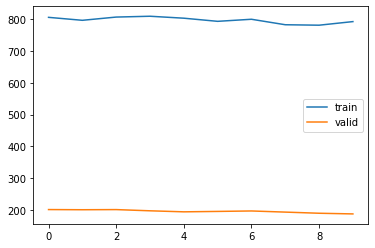

In [48]:





# ## DIST IOU LOSS
# criterion = distance_box_iou_loss
# criterion_handler = lambda pred, actual: criterion(pred.view(-1, 4), actual.view(-1, 4), reduction = 'sum')
## L1 LOSS
criterion = nn.SmoothL1Loss() 
criterion_handler = lambda pred, actual: criterion(pred, torch.flatten(actual, 1))

net1 = ObjectDetectorROI(16)#ObjectDetector(16)

optimizer = optim.Adam(net1.parameters(), lr = LR, weight_decay=WD) 
model_results1 = train_and_validate(net1, 10, trainDL, testDL, criterion_handler, optimizer, k = 5)
pd.DataFrame(model_results1).plot();

In [ ]:
net1

EPOCH: 25 training loss: 298.722 validation loss: 79.746
EPOCH: 50 training loss: 273.185 validation loss: 69.423
EPOCH: 75 training loss: 261.944 validation loss: 69.774
EPOCH: 100 training loss: 262.099 validation loss: 68.549
EPOCH: 125 training loss: 238.637 validation loss: 57.750
EPOCH: 150 training loss: 205.934 validation loss: 59.337
EPOCH: 175 training loss: 210.714 validation loss: 54.061
EPOCH: 200 training loss: 197.195 validation loss: 54.093
EPOCH: 225 training loss: 204.670 validation loss: 52.383
EPOCH: 250 training loss: 188.815 validation loss: 52.383
EPOCH: 275 training loss: 175.848 validation loss: 51.439
EPOCH: 300 training loss: 165.831 validation loss: 50.795
EPOCH: 325 training loss: 177.729 validation loss: 48.273
EPOCH: 350 training loss: 178.569 validation loss: 48.034
EPOCH: 375 training loss: 162.139 validation loss: 48.539
EPOCH: 400 training loss: 162.139 validation loss: 50.911
EPOCH: 425 training loss: 162.666 validation loss: 49.392
EPOCH: 450 traini

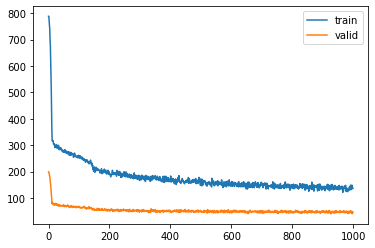

In [196]:
## L1 LOSS
criterion = nn.SmoothL1Loss() 
criterion_handler = lambda pred, actual: criterion(pred, torch.flatten(actual, 1))

net2 = ObjectDetector(16)

optimizer = optim.Adam(net2.parameters(), lr = 1.0e-04, weight_decay=0) 
model_results2 = train_and_validate(net2, EPOCHS, trainDL, testDL, criterion_handler, optimizer, k = K)
pd.DataFrame(model_results2).plot();

In [261]:
del net

EPOCH: 10 training loss: 579.820 validation loss: 135.575
EPOCH: 20 training loss: 353.837 validation loss: 88.290
EPOCH: 30 training loss: 346.700 validation loss: 84.283
EPOCH: 40 training loss: 328.914 validation loss: 81.126
EPOCH: 50 training loss: 335.371 validation loss: 80.756
EPOCH: 60 training loss: 319.774 validation loss: 82.098
EPOCH: 70 training loss: 326.431 validation loss: 78.120
EPOCH: 80 training loss: 323.675 validation loss: 84.530
EPOCH: 90 training loss: 329.613 validation loss: 80.324
EPOCH: 100 training loss: 324.251 validation loss: 81.981


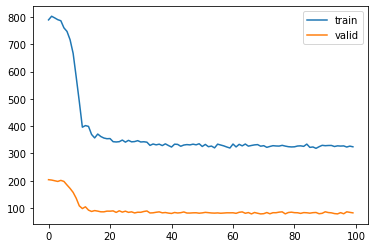

In [19]:
## L1 LOSS
criterion = nn.SmoothL1Loss() 
criterion_handler = lambda pred, actual: criterion(pred, torch.flatten(actual, 1))

net3 = ObjectDetector2(16)

optimizer = optim.Adam(net3.parameters(), lr = 1.0e-04, weight_decay=1.0e-05) 
model_results3 = train_and_validate(net3, 100, trainDL, testDL, criterion_handler, optimizer, k = 10)
pd.DataFrame(model_results3).plot();

EPOCH: 10 training loss: 483.182 validation loss: 121.380
EPOCH: 20 training loss: 443.538 validation loss: 108.502
EPOCH: 30 training loss: 426.775 validation loss: 109.701
EPOCH: 40 training loss: 414.144 validation loss: 103.674
EPOCH: 50 training loss: 404.724 validation loss: 102.643
EPOCH: 60 training loss: 389.985 validation loss: 100.893
EPOCH: 70 training loss: 391.318 validation loss: 97.959
EPOCH: 80 training loss: 379.813 validation loss: 99.034
EPOCH: 90 training loss: 360.759 validation loss: 90.363
EPOCH: 100 training loss: 350.719 validation loss: 88.932
EPOCH: 110 training loss: 339.691 validation loss: 85.441
EPOCH: 120 training loss: 309.101 validation loss: 80.527
EPOCH: 130 training loss: 283.432 validation loss: 77.321
EPOCH: 140 training loss: 284.464 validation loss: 73.827
EPOCH: 150 training loss: 278.681 validation loss: 75.019
EPOCH: 160 training loss: 272.876 validation loss: 69.075
EPOCH: 170 training loss: 271.639 validation loss: 73.777
EPOCH: 180 traini

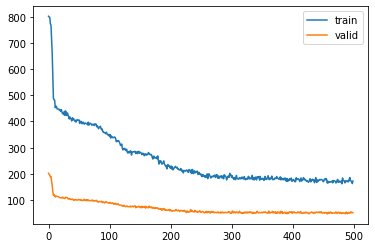

In [35]:
## L1 LOSS
criterion = nn.SmoothL1Loss() 
criterion_handler = lambda pred, actual: criterion(pred, torch.flatten(actual, 1))

net4 = ObjectDetector2_res(16)

optimizer = optim.Adam(net4.parameters(), lr = 1.0e-04, weight_decay=1.0e-05) 
model_results4 = train_and_validate(net4, 500, trainDL, testDL, criterion_handler, optimizer, k = 10)
pd.DataFrame(model_results4).plot();

EPOCH: 10 training loss: 236.339 validation loss: 59.577
EPOCH: 20 training loss: 228.532 validation loss: 60.880
EPOCH: 30 training loss: 234.577 validation loss: 54.461
EPOCH: 40 training loss: 239.266 validation loss: 55.001
EPOCH: 50 training loss: 229.252 validation loss: 55.905
EPOCH: 60 training loss: 223.007 validation loss: 56.201
EPOCH: 70 training loss: 221.943 validation loss: 55.623
EPOCH: 80 training loss: 203.908 validation loss: 53.939
EPOCH: 90 training loss: 198.529 validation loss: 52.674
EPOCH: 100 training loss: 177.765 validation loss: 50.668
EPOCH: 110 training loss: 177.154 validation loss: 49.213
EPOCH: 120 training loss: 165.891 validation loss: 46.053
EPOCH: 130 training loss: 154.164 validation loss: 47.019
EPOCH: 140 training loss: 134.184 validation loss: 42.554
EPOCH: 150 training loss: 144.397 validation loss: 47.430
EPOCH: 160 training loss: 157.000 validation loss: 47.864
EPOCH: 170 training loss: 141.537 validation loss: 41.921
EPOCH: 180 training los

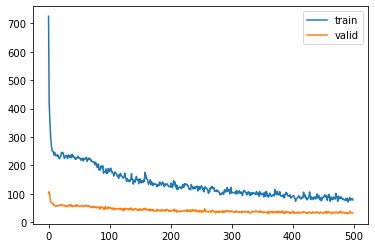

In [39]:
## L1 LOSS
criterion = nn.SmoothL1Loss() 
criterion_handler = lambda pred, actual: criterion(pred, torch.flatten(actual, 1))

net5 = ObjectDetector2_res_deep(16)

optimizer = optim.Adam(net5.parameters(), lr = 1.0e-03, weight_decay=1.0e-05) 
model_results5 = train_and_validate(net5, 500, trainDL, testDL, criterion_handler, optimizer, k = 10)
pd.DataFrame(model_results5).plot();

EPOCH: 25 training loss: 71.719 validation loss: 29.016
EPOCH: 50 training loss: 69.253 validation loss: 31.468
EPOCH: 75 training loss: 69.837 validation loss: 33.588
EPOCH: 100 training loss: 76.932 validation loss: 30.858
EPOCH: 125 training loss: 75.235 validation loss: 32.050
EPOCH: 150 training loss: 63.897 validation loss: 31.781
EPOCH: 175 training loss: 58.551 validation loss: 32.571
EPOCH: 200 training loss: 65.144 validation loss: 30.157
EPOCH: 225 training loss: 63.028 validation loss: 33.315
EPOCH: 250 training loss: 64.716 validation loss: 31.246
EPOCH: 275 training loss: 65.750 validation loss: 31.788
EPOCH: 300 training loss: 70.553 validation loss: 30.226
EPOCH: 325 training loss: 60.677 validation loss: 30.833
EPOCH: 350 training loss: 60.599 validation loss: 31.719
EPOCH: 375 training loss: 66.059 validation loss: 33.560
EPOCH: 400 training loss: 65.163 validation loss: 28.821
EPOCH: 425 training loss: 57.218 validation loss: 32.875
EPOCH: 450 training loss: 62.612 v

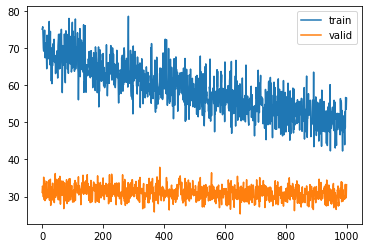

In [91]:
# train some more with smaller learning rate
optimizer = optim.Adam(net5.parameters(), lr = 1.0e-04, weight_decay=1.0e-05) 
model_results5 = train_and_validate(net5, 1000, trainDL, testDL, criterion_handler, optimizer, k = 25)
pd.DataFrame(model_results5).plot();

EPOCH: 20 training loss: 2188.919 validation loss: 565.367
EPOCH: 40 training loss: 2135.631 validation loss: 556.297
EPOCH: 60 training loss: 2133.972 validation loss: 555.422
EPOCH: 80 training loss: 2116.841 validation loss: 553.494
EPOCH: 100 training loss: 2111.516 validation loss: 555.548
EPOCH: 120 training loss: 2129.323 validation loss: 555.431
EPOCH: 140 training loss: 2110.517 validation loss: 552.101
EPOCH: 160 training loss: 2114.818 validation loss: 553.138
EPOCH: 180 training loss: 2124.344 validation loss: 552.577
EPOCH: 200 training loss: 2099.067 validation loss: 549.151


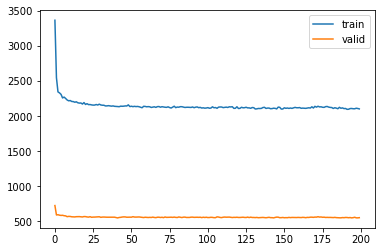

In [96]:
## Combined LOSS
criterion1 = nn.L1Loss() 
criterion_handler1 = lambda pred, actual: criterion1(pred, torch.flatten(actual, 1))

criterion2 = distance_box_iou_loss
criterion_handler2 = lambda pred, actual: criterion2(pred.view(-1, 4), actual.view(-1, 4), reduction = 'sum')

criterion_handler = lambda pred, actual: 0.5 * criterion_handler1(pred, actual) + 0.5 * criterion_handler2(pred, actual)

net2 = ObjectDetector(16)

optimizer = optim.Adam(net2.parameters(), lr = 0.001, weight_decay=WD) 
model_results2 = train_and_validate(net2, 200, trainDL, testDL, criterion_handler, optimizer, k = 20)
pd.DataFrame(model_results2).plot();

EPOCH: 5 training loss: 327.895 validation loss: 80.941
EPOCH: 10 training loss: 292.471 validation loss: 71.489
EPOCH: 15 training loss: 281.250 validation loss: 68.810
EPOCH: 20 training loss: 276.368 validation loss: 68.343
EPOCH: 25 training loss: 254.615 validation loss: 65.826
EPOCH: 30 training loss: 254.641 validation loss: 66.258
EPOCH: 35 training loss: 238.665 validation loss: 68.753
EPOCH: 40 training loss: 232.504 validation loss: 61.445
EPOCH: 45 training loss: 215.897 validation loss: 61.643
EPOCH: 50 training loss: 210.140 validation loss: 58.407


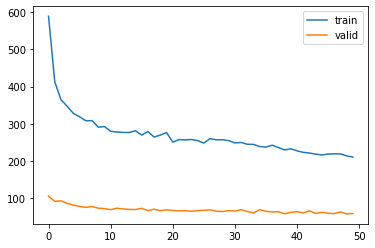

In [164]:
## L1 LOSS
criterion = nn.SmoothL1Loss() 
criterion_handler = lambda pred, actual: criterion(pred, torch.flatten(actual, 1))

net3 = ObjectDetector(16)

optimizer = optim.Adam(net3.parameters(), lr = LR, weight_decay=0) 
model_results3 = train_and_validate(net3, 50, trainDL, testDL, criterion_handler, optimizer, k = 5)
pd.DataFrame(model_results3).plot();

## Try with pre-trained resnet model

In [21]:
from torchvision.models import resnet18

resnet = resnet18(weights = 'ResNet18_Weights.IMAGENET1K_V1')

In [22]:
## DIST IOU LOSS
criterion = distance_box_iou_loss
criterion_handler = lambda pred, actual: criterion(pred.view(-1, 4), actual.view(-1, 4), reduction = 'sum')

net4 = resnet_ObjectDetector(resnet,16)

optimizer = optim.Adam(net4.parameters(), lr = LR, weight_decay=WD) 
model_results4 = train_and_validate(net4, RESNET_EPOCHS, trainDL, testDL, criterion_handler, optimizer, k = K)
pd.DataFrame(model_results4).plot();

EPOCH: 1 training loss: 6123.719 validation loss: 1553.246
EPOCH: 2 training loss: 6128.926 validation loss: 1549.537
EPOCH: 3 training loss: 6113.446 validation loss: 1556.039
EPOCH: 4 training loss: 6109.576 validation loss: 1549.447
EPOCH: 5 training loss: 6124.348 validation loss: 1541.432
EPOCH: 6 training loss: 6120.741 validation loss: 1547.130
EPOCH: 7 training loss: 6122.742 validation loss: 1543.293
EPOCH: 8 training loss: 6116.739 validation loss: 1557.395
EPOCH: 9 training loss: 6123.186 validation loss: 1547.338
EPOCH: 10 training loss: 6111.194 validation loss: 1539.454
EPOCH: 11 training loss: 6109.498 validation loss: 1545.642
EPOCH: 12 training loss: 6109.438 validation loss: 1550.521
EPOCH: 13 training loss: 6097.183 validation loss: 1544.921
EPOCH: 14 training loss: 6109.485 validation loss: 1541.461
EPOCH: 15 training loss: 6095.264 validation loss: 1536.484
EPOCH: 16 training loss: 6096.470 validation loss: 1540.418
EPOCH: 17 training loss: 6096.292 validation loss

EPOCH: 1 training loss: 25778.173 validation loss: 6595.149
EPOCH: 11 training loss: 24426.711 validation loss: 6441.133
EPOCH: 21 training loss: 23951.865 validation loss: 5944.312
EPOCH: 31 training loss: 23382.914 validation loss: 5900.313
EPOCH: 41 training loss: 23903.856 validation loss: 6025.008
EPOCH: 51 training loss: 23319.222 validation loss: 5902.546
EPOCH: 61 training loss: 23437.334 validation loss: 5740.798
EPOCH: 71 training loss: 23707.235 validation loss: 5864.826
EPOCH: 81 training loss: 23383.458 validation loss: 5699.610
EPOCH: 91 training loss: 22896.764 validation loss: 5809.146


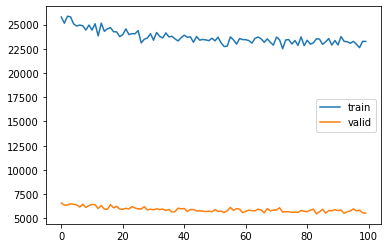

In [ ]:
## MSE LOSS
criterion = nn.MSELoss() 
criterion_handler = lambda pred, actual: criterion(pred, torch.flatten(actual, 1))

net5 = resnet_ObjectDetector(resnet,16)

optimizer = optim.Adam(net5.parameters(), lr = LR, weight_decay=WD) 
model_results5 = train_and_validate(net5, RESNET_EPOCHS, trainDL, testDL, criterion_handler, optimizer, k = 1)
pd.DataFrame(model_results5).plot();

<AxesSubplot:>

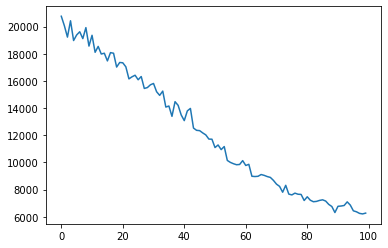

In [ ]:
## L1 LOSS
criterion = nn.L1Loss() 
criterion_handler = lambda pred, actual: criterion(pred, torch.flatten(actual, 1))

net6 = resnet_ObjectDetector(resnet,16)

optimizer = optim.Adam(net6.parameters(), lr = LR, weight_decay=WD) 
model_results6 = train_and_validate(net6, RESNET_EPOCHS, trainDL, testDL, criterion_handler, optimizer, k = 1)
pd.DataFrame(model_results6).plot();

## have a look at the results

In [49]:
k = iter(testFiles)
# k = iter(trainFiles)

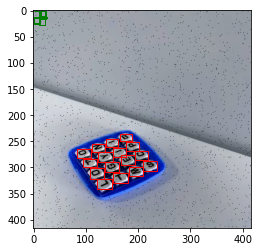

In [63]:
img, _, bbox = next(k)

plotODResults(img[None, : ], bbox, net1, prediction = True)
# plotODResults(img[None, : ], bbox, net4, prediction = True)
# plotODResults(img[None, : ], bbox, net3, prediction = True)